## References

This notebook is based on the following paper:  

**Dietrich Wettschereck and Thomas G. Dietterich.** *An Experimental Comparison of the Nearest-Neighbor and Nearest-Hyperrectangle Algorithms.* Machine-mediated learning, 1995. DOI: [10.1007/BF00994658](https://doi.org/10.1007/BF00994658).


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys

sys.path.append("../..")

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

seed = 256
torch.manual_seed(seed)
np.random.seed(seed)

In [15]:
from matplotlib.patches import Rectangle


def plot_hypercubes(
    ax, hypercubes: torch.Tensor, base_prediction: torch.Tensor, colors, alpha=0.4
):
    for h, bp in zip(hypercubes, base_prediction):
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(
            low,
            side_lengths[0],
            side_lengths[1],
            facecolor=colors[int(bp)],
            alpha=alpha,
        )
        ax.add_patch(patch)

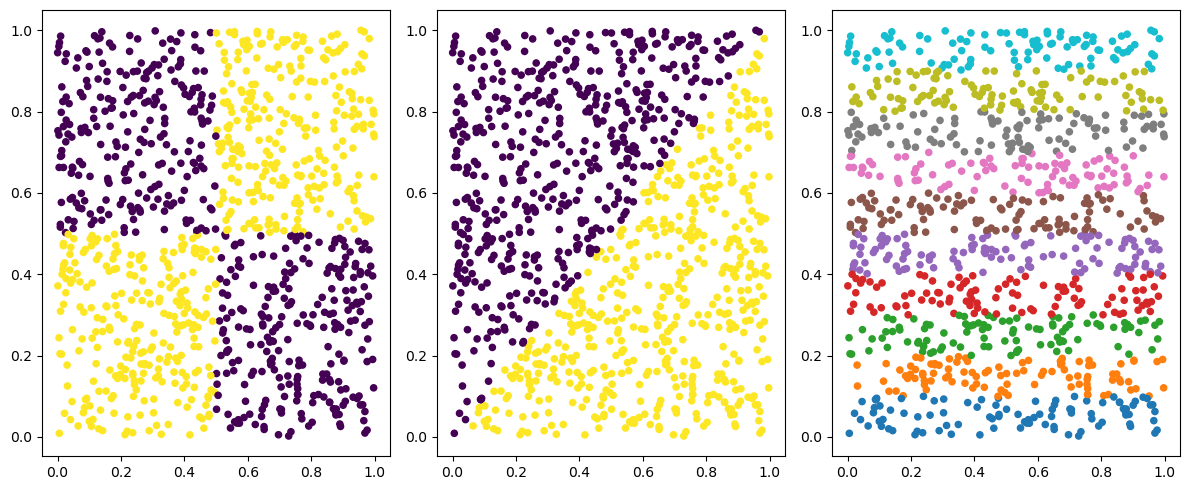

In [23]:
n_samples = 1000

datas = torch.rand((n_samples, 2))

# Dataset 1
mask_dataset1 = ((datas[:, 0] <= 0.5) & (datas[:, 1] > 0.5)) | (
    (datas[:, 0] > 0.5) & (datas[:, 1] <= 0.5)
)

labels1 = torch.zeros(n_samples)
labels1[~mask_dataset1] = 1

# Dataset 2
mask_dataset2 = datas[:, 0] <= datas[:, 1]

labels2 = torch.zeros(n_samples)
labels2[~mask_dataset2] = 1

# Dataset 3
labels3 = torch.zeros(n_samples)

for i in torch.arange(0, 1, 0.1):
    mask_dataset3 = (datas[:, 1] > i) & (datas[:, 1] <= i + 0.1)
    labels3[mask_dataset3] = int(i * 10)


# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].scatter(datas[:, 0], datas[:, 1], s=20, c=labels1)
axs[1].scatter(datas[:, 0], datas[:, 1], s=20, c=labels2)
axs[2].scatter(datas[:, 0], datas[:, 1], s=20, c=labels3, cmap="tab10")

plt.tight_layout()
plt.show()

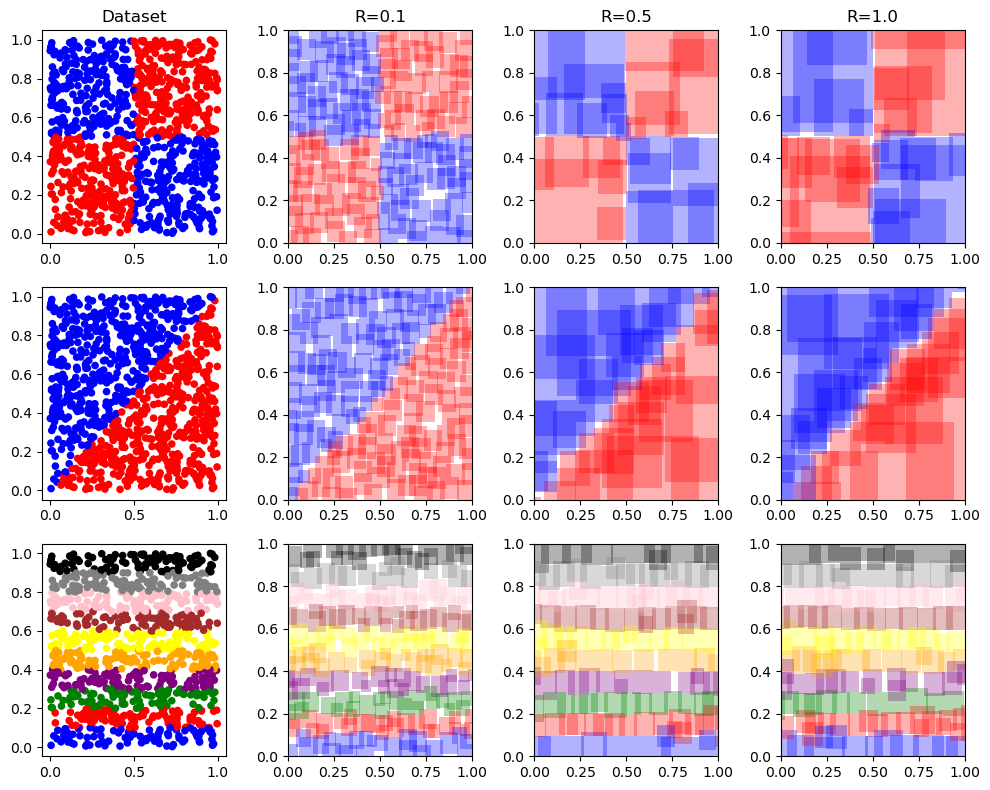

In [33]:
from torch_mas.sequential.trainer import ClassifTrainer as Trainer
from torch_mas.sequential.internal_model import NClass
from torch_mas.sequential.activation_function import BaseActivation

from torch_mas.data import DataBuffer

from matplotlib.colors import ListedColormap


colors = [
    ["blue", "red"],
    ["blue", "red"],
    [
        "blue",
        "red",
        "green",
        "purple",
        "orange",
        "yellow",
        "brown",
        "pink",
        "grey",
        "black",
    ],
]

nrows, ncols = 3, 4
fig = plt.figure(figsize=(10, 8))

n_plot = 1

for label, color in zip([labels1, labels2, labels3], colors):
    ax = fig.add_subplot(nrows, ncols, n_plot)
    ax.scatter(datas[:, 0], datas[:, 1], s=20, c=label, cmap=ListedColormap(color))
    n_plot += 1

    dataset = DataBuffer(datas, label.unsqueeze(1))

    for r in [0.1, 0.5, 1.0]:
        validity = BaseActivation(
            dataset.input_dim,
            dataset.output_dim,
            alpha=0.1,
        )
        internal_model = NClass(
            dataset.input_dim,
            dataset.output_dim,
            memory_length=10,
        )
        model = Trainer(
            validity,
            internal_model,
            R=r,
            imprecise_th=0.0015,
            bad_th=0.1,
            n_epochs=5,
        )

        model.fit(dataset)

        ax = fig.add_subplot(nrows, ncols, n_plot)
        plot_hypercubes(
            ax,
            model.activation.orthotopes.detach().numpy(),
            model.internal_model.base_prediction.numpy(),
            colors=color,
            alpha=0.3,
        )
        n_plot += 1


cols = ["Dataset", "R=0.1", "R=0.5", "R=1.0"]
for ax, col in zip(fig.get_axes()[0:ncols], cols):
    ax.set_title(col)

plt.tight_layout()
plt.show()